## Задача: Определение близости статей по их абстракту

In [1]:
import warnings
from collections import Counter
from functools import reduce
from tqdm import tqdm
import numpy as np
import dask.array as da
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader
from string import punctuation
from gensim.models import Word2Vec, KeyedVectors
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE

C:\Users\adovd\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
gensim.__version__

'4.0.0'

In [3]:
warnings.filterwarnings("ignore")

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adovd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Считывание данных в Pandas Dataframe

In [5]:
df = pd.read_csv('nature_10.csv', sep=';', encoding='latin-1')

In [6]:
df.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13
0,Chromatin remodeling regulated by steroid and ...,Cell Research,1748-7838,10.1038/cr.1997.14,7.0,2.0,1997.0,127-142,"Wolffe, Alan P","Wolffe, Alan P#:#Laboratory of Molecular Embro...",Coactivators and corepressors regulate transcr...,citation_journal_title=Ann Rev Genet; citation...,NaN
1,Biochemical detection of alien DNA incorporate...,Heredity,1365-2540,10.1038/hdy.1978.49,40.0,3.0,1978.0,439-455,"Flavell, Richard;O'Dell, Michael;Rimpau, J?rge...","Flavell, Richard#:#Department of Cytogenetics,...",Wheat lines carrying homologous pairs of compl...,"Barber, H N, Driscoll, C J, and Vickery, R S. ...",NaN
2,Early Archaean Age for the Isua Iron Formation...,Nature,1476-4687,10.1038/245138a0,245.0,5421.0,1973.0,138-139,"MOORBATH, S.;O'NIONS, R. K.;PANKHURST, R. J.","MOORBATH, S.#:#Department of Geology, Universi...","SOME 150 km north-east of Godthaab, on the edg...",citation_journal_title=Nature; citation_author...,NaN
3,Technical Education Abstracts,Nature,1476-4687,10.1038/193222a0,193.0,4812.0,1962.0,222-222,NaN,NaN,NaN,NaN,NaN
4,The Utility of Specific Characters,Nature,1476-4687,10.1038/054365b0,54.0,1399.0,1896.0,365-366,"LANKESTER, E. RAY","LANKESTER, E. RAY#:#Dinard, Bretagne",I REGRET very much that I did not correctly re...,NaN,NaN


### Выявляение и устранение пропусков в данных(NaN)

<AxesSubplot:>

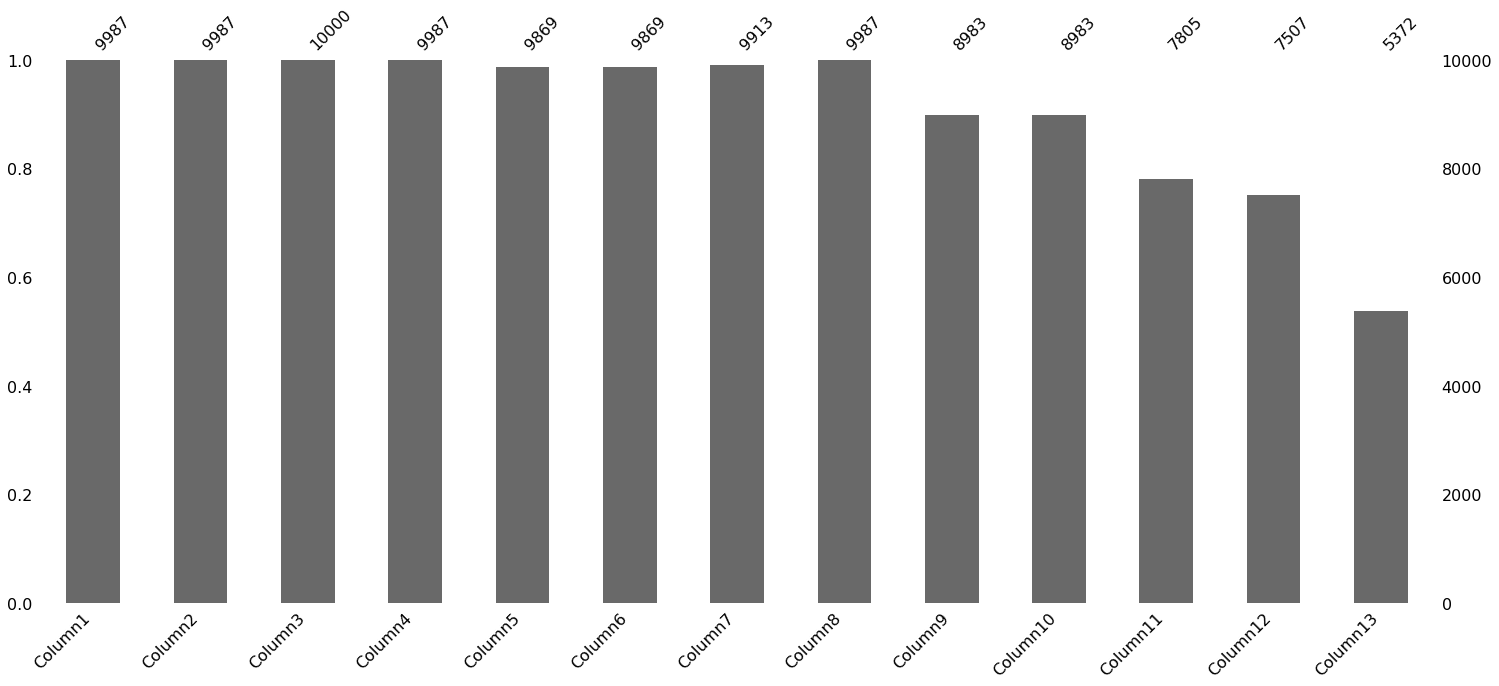

In [7]:
msno.bar(df)

In [8]:
df.dropna(subset=['Column11', 'Column2'], inplace=True)

### Препроцессинг данных (Токенизация + Лемматизация + Удаление стоп слов)

In [9]:
stop_words = list(stopwords.words('english')) 
tokenizer = WordPunctTokenizer()
lem = WordNetLemmatizer()

In [10]:
source_series = df['Column11']

In [11]:
Train = df['Column11'].apply(lambda x: tokenizer.tokenize(x.lower()))
Train = Train.apply(lambda row: [lem.lemmatize(word) for word in row if (word not in stop_words) and (word not in punctuation)])

In [12]:
Train

0       [coactivators, corepressors, regulate, transcr...
1       [wheat, line, carrying, homologous, pair, comp...
2       [150, km, north, east, godthaab, edge, inland,...
4       [regret, much, correctly, remember, writing, n...
6       [experimentally, restricted, placental, growth...
                              ...                        
9993    [irrigated, agriculture, south, asia, depends,...
9995    [selective, synthesis, fluorinated, organic, m...
9997    [wnt, signal, transduction, pathway, induces, ...
9998    [phytochrome, b, phyb, primary, red, light, ph...
9999    [occurrence, glioma, brain, fowl, reported, be...
Name: Column11, Length: 7792, dtype: object

### Первая модель: CountVectorizer + Cos_similiraty

In [13]:
countvectorizer = CountVectorizer(min_df=3)

In [14]:
new_corpus = countvectorizer.fit_transform(source_series);
new_corpus.shape

(7792, 17539)

In [15]:
X_embedded = TSNE(init="random",metric='cosine').fit_transform(new_corpus)

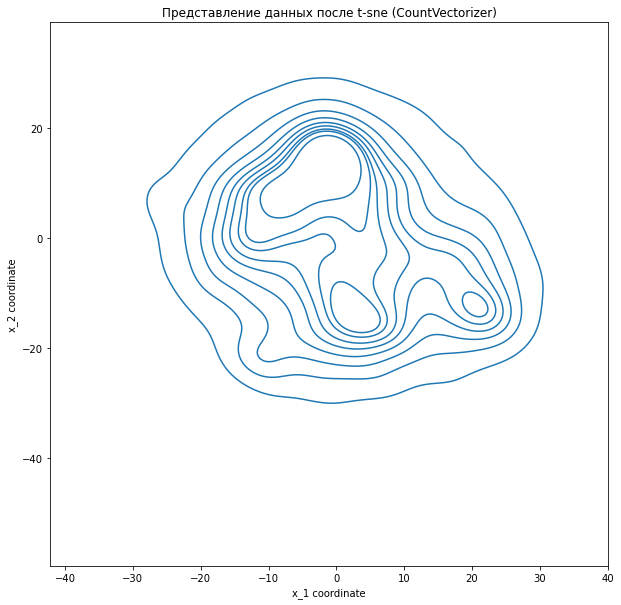

In [16]:
fig = plt.figure(figsize=(10,10))
ax = sns.kdeplot(x=X_embedded[:,0],
                 y=X_embedded[:,1]
)
ax.set_title('Представление данных после t-sne (CountVectorizer)')
ax.set_xlabel('x_1 coordinate')
ax.set_ylabel('x_2 coordinate')
plt.show()

### Вторая модель: TF_IDF + Cos_similiraty

In [17]:
tf_idf = TfidfVectorizer()

In [18]:
matrix = tf_idf.fit_transform(source_series)

In [19]:
tfidf_emb = TSNE(init='random', metric='cosine').fit_transform(matrix)

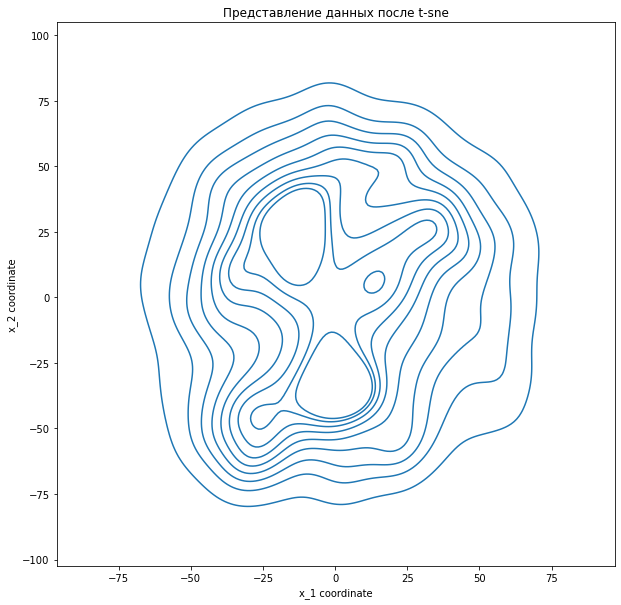

In [20]:
fig = plt.figure(figsize=(10,10))
ax = sns.kdeplot(x=tfidf_emb[:,0], y=tfidf_emb[:,1])
ax.set_title('Представление данных после t-sne')
ax.set_xlabel('x_1 coordinate')
ax.set_ylabel('x_2 coordinate')
plt.show()

### Третья модель: Word2Vec + Cos_similiraty

In [21]:
model = Word2Vec(Train, 
                 vector_size=300,
                 min_count=3,
                 epochs=50)

In [22]:
class aggregation(object):
    def __init__(self, model):
        self.model = model
        
    
    def get_embedding(self, word):
        try:
            return self.model.wv[word]
        
        except:
            return np.array([0] * 300)
    
    def agg_sentences(self, corpus):
        return corpus.apply(lambda row: reduce(lambda cur, nex: cur + self.get_embedding(nex),
                                               row,
                                               np.array([0] * 300)
                                              ) / len(row)
                           )

    
    
        
    
    
    

In [23]:
agg = aggregation(model)

In [24]:
embeddings = pd.DataFrame(agg.agg_sentences(Train))
embeddings = da.from_array(embeddings['Column11'].apply(pd.Series).values)

In [25]:
emb_simple_wv = TSNE(metric='cosine').fit_transform(embeddings)

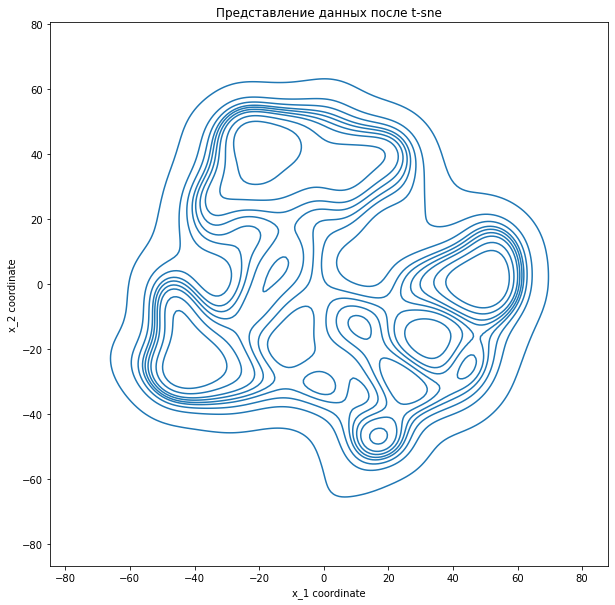

In [26]:
fig = plt.figure(figsize=(10,10))
ax = sns.kdeplot(x=emb_simple_wv[:,0], y=emb_simple_wv[:,1])
ax.set_title('Представление данных после t-sne')
ax.set_xlabel('x_1 coordinate')
ax.set_ylabel('x_2 coordinate')
plt.show()

3it [00:00, 2997.36it/s]


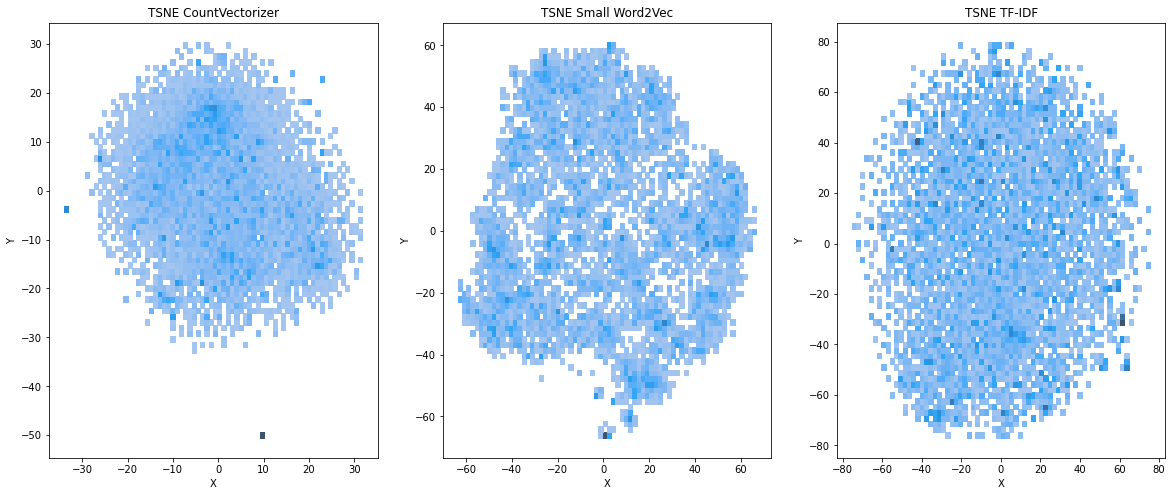

In [48]:
bins = 70
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,8))

sns.histplot(x=X_embedded[:,0],
            y=X_embedded[:,1],
            ax=ax1, 
            bins=bins)

sns.histplot(x=emb_simple_wv[:,0],
            y=emb_simple_wv[:,1],
            ax=ax2,
            bins=bins)

sns.histplot(x=tfidf_emb[:,0],
            y=tfidf_emb[:,1],
            ax=ax3,
            bins=bins)

for ax, text in tqdm(zip((ax1, ax2, ax3), ('TSNE CountVectorizer','TSNE Small Word2Vec','TSNE TF-IDF'))):
    ax.set_title(text)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
plt.show()